# Section 4

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams.update({
    #"text.usetex": True,
    "font.family": "serif",
    "font.size": 16
})

## Legendere polynomials

In [2]:
from scipy.special import eval_legendre

nx = 1000
nvec = np.arange(4)
xvec = np.linspace(-1, 1, nx)
legval = eval_legendre(nvec[None,:], xvec[:,None])
print(legval.shape)

(1000, 4)


''

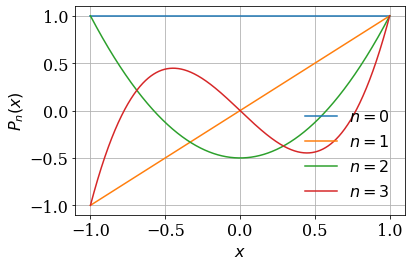

In [3]:
for n in nvec:
    plt.plot(xvec, legval[:,n], label=r'$n='+str(n)+r'$')
plt.grid()
plt.legend(loc='best', frameon=False)
plt.xlabel(r'$x$')
plt.ylabel(r'$P_n(x)$')
plt.tight_layout()
plt.savefig('legendre_polynomials.pdf', transparent=True)
;

## Distribution of zeros

Note that the nodes of Gauss quadrature of degree $n$ is the roots of $P_n(x)$.

In [4]:
from numpy.polynomial.legendre import leggauss

x_, _ = leggauss(deg=3)
x_

array([-0.77459667,  0.        ,  0.77459667])

In [5]:
# zeros of P_10000(x)
zeros4, _ = leggauss(deg=10000)
dens4, bins = np.histogram(zeros4, bins=1000, density=True)

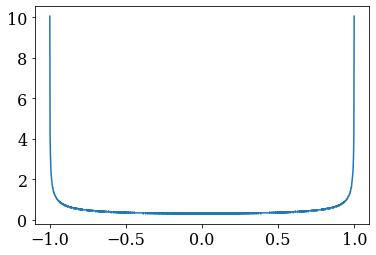

In [6]:
bin_cent = 0.5*(bins[:-1]+bins[1:])
plt.plot(bin_cent, dens4)

## Example: Hubbard atom

Note: The Gauss-Legendre quadrature of degree $n$ yields the exact results for a polynomial of degree $2n-1$.

In [7]:
from hubbard_atom import *

In [8]:
N = 100 # Dim of Legendre basis

# Quadrature rule over interval [0, beta]
x, y = leggauss(deg=N)
taus_leggauss = beta * (x+1)/2
weights_leggauss = (beta/2) * y

# Expand the Green's function in Legendre basis
lvec = np.arange(N)
legg_val = eval_legendre(lvec[None,:], x[:,None])
gtau_val = gtau(taus_leggauss)

print("beta=", beta)
gl = np.einsum('l,tl,t,t->l',
               np.sqrt(2*lvec+1),
               legg_val,
               gtau_val,
               weights_leggauss, optimize=True)

beta= 300.0


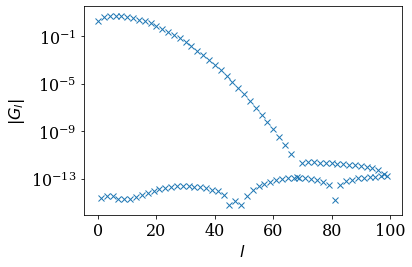

In [9]:
# The expansion coefficients for odd l are zeros due to 
# the particle-hole symmetry.
plt.semilogy(lvec, np.abs(gl), marker='x', ls='')
plt.xlabel(r'$l$')
plt.ylabel(r'$|G_l|$')
plt.tight_layout()
plt.savefig('legendre_hubbard_atom.pdf', transparent=True)

In [10]:
import scipy

def compute_Tnl(vsample, n_legendre):
    """
    Compute transformation matrix from Legendre to fermionic/bosonic Matsubara frequency
    Implement Eq. (4.5) in the Boehnke's  Ph.D thesis
    """
    Tnl = np.zeros((vsample.size, n_legendre), dtype=np.complex128)
    for idx_n, v in enumerate(vsample):
        abs_v = abs(v)
        sph_jn = np.array(
            [scipy.special.spherical_jn(l, 0.5*abs_v*np.pi) for l in range(n_legendre)])
        for il in range(n_legendre):
            Tnl[idx_n, il] = (1J**(abs_v+il)) * np.sqrt(2*il + 1.0) * sph_jn[il]
        if v < 0:
            Tnl[idx_n, :] = Tnl[idx_n, :].conj()
    return Tnl

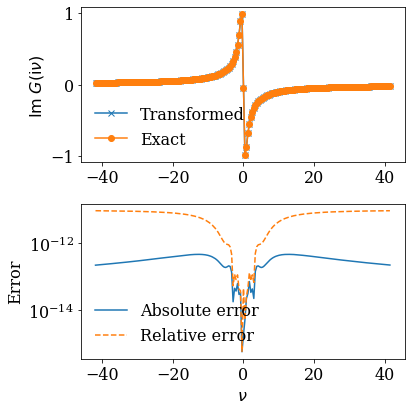

In [11]:
# Matsubara frequencies (every 20 points)
v = 2*np.arange(-2000, 2000, 20)+1
giv_exact = giv(v)
giv_approx = compute_Tnl(v, N) @ gl

fig = plt.figure(figsize=(6,6))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212, sharex = ax1)
axes = [ax1, ax2]

ax1.plot(v * np.pi/beta, giv_approx.imag, label='Transformed', marker='x')
ax1.plot(v * np.pi/beta, giv_exact.imag, label='Exact', marker='o')
ax2.semilogy(v * np.pi/beta, np.abs(giv_exact-giv_approx), label='Absolute error', marker='', ls='-')
ax2.semilogy(v * np.pi/beta, np.abs((giv_exact-giv_approx)/giv_exact), label='Relative error', marker='', ls='--')

ax2.set_xlabel(r'$\nu$')
ax1.set_ylabel(r'$\mathrm{Im}~G(\mathrm{i}\nu)$')
ax2.set_ylabel(r'Error')

ax1.legend(frameon=False, loc='best')
ax2.legend(frameon=False)
plt.tight_layout()
plt.tight_layout()
plt.savefig('legendre_matsu_hubbard_atom.pdf', transparent=True)